In [28]:
import pandas as pd
import numpy as np

import pymc3 as pm
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Format floats without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [29]:
data = pd.read_csv("../data/cscareerquestions.csv")

data = data.rename(columns = {'What is your gross annualized base pay? (Multiply your monthly pay by 12.)':'base_pay'})
data = data.rename(columns = {'How old are you?':'age'})
data = data.rename(columns = {'How many hours do you work in a normal week?':'hours'})

data.base_pay = data.base_pay[np.abs(data.base_pay-data.base_pay.mean())<=(3*data.base_pay.std())]  # Remove Outlier
data.base_pay = data.base_pay[(data.base_pay <= 500000) & (data.base_pay >= 15600)] # only consider salary under 500k and above usa minimum wage
data.hours = data.hours[data.hours >= 35]  # only consider full-time
data.age = data.age[data.age >= 18]  # only consider legal working age
data.base_pay = np.round(data.base_pay)  # Make finite

data = data[['age', 'base_pay', 'hours']].dropna()[['age', 'base_pay']]

print(data.describe())

          age   base_pay
count 792.000    792.000
mean   27.212  90020.429
std     4.949  42190.473
min    19.000  16800.000
25%    24.000  63000.000
50%    26.000  80000.000
75%    30.000 110000.000
max    51.000 400000.000


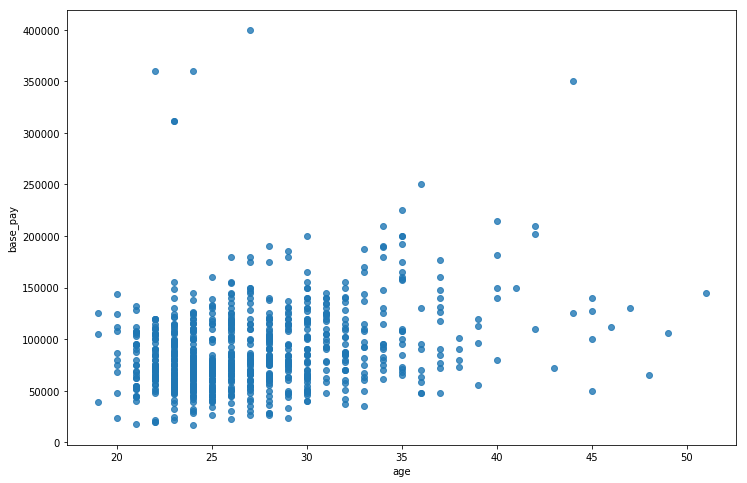

In [30]:
plt.figure(figsize=(12,8))
sns.regplot(x='age', y='base_pay', data=data, fit_reg=False)
plt.ticklabel_format(style='plain', axis='y')

In [31]:
samples = 10000

with pm.Model() as linear_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=45000, sd=20000)
    beta = pm.Normal('beta', mu=5000, sd=10000)
    sigma = pm.HalfNormal('sigma', sd=10000)

    # Expected value of outcome
    mu = alpha + beta*data.age.values

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('base_pay_obs', mu=mu, sd=sigma, observed=data.base_pay.values)

    # Posterior distribution
    linear_trace = pm.sample(samples)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 10500/10500 [00:27<00:00, 383.56it/s]
The acceptance probability does not match the target. It is 0.8828324307807967, but should be close to 0.8. Try to increase the number of tuning steps.


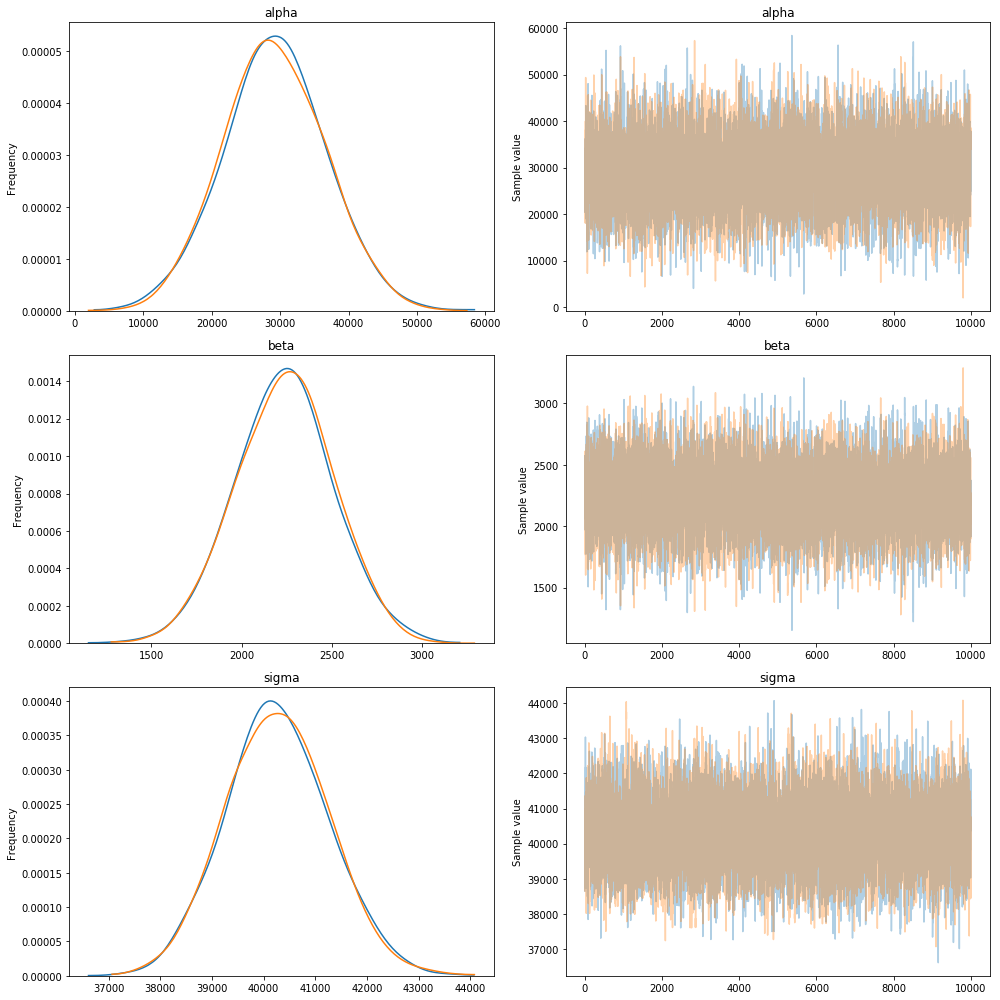

In [32]:
pm.traceplot(linear_trace, figsize = (14, 14));

In [33]:
pm.summary(linear_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,29217.824,7437.123,85.813,14959.688,44238.386,7391.260,1.000
beta,2237.994,268.844,3.134,1710.832,2766.813,7422.101,1.000
sigma,40270.141,988.892,9.362,38339.455,42185.927,9561.902,1.000


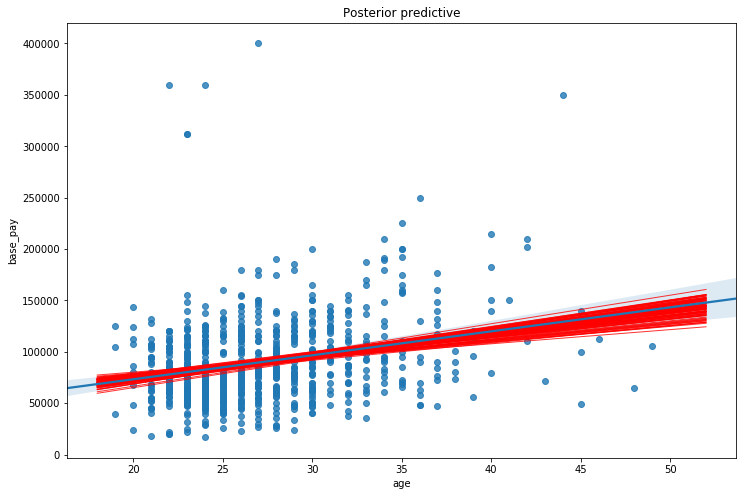

In [34]:
plt.figure(figsize = (12, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(np.min(data.age)-1, np.max(data.age)+1, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['alpha'] + sample['beta'] * x)
sns.regplot(x='age', y='base_pay', data=data)
plt.ticklabel_format(style='plain', axis='y')

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


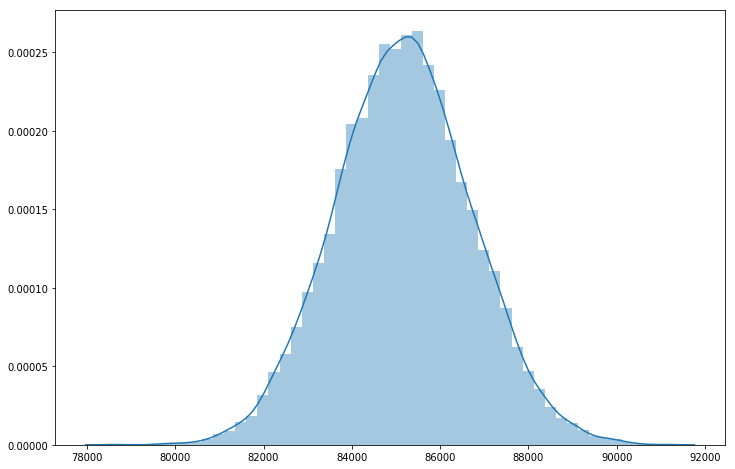

Model Mu: 85167.66 Model Sigma: 1543.13
Model Percentile: 1.00


In [35]:
test_age = 25
test_pay = 115000

plt.figure(figsize=(12,8))
sns.distplot(linear_trace['alpha'] + linear_trace['beta'] * test_age)
plt.show()

model_mean = np.mean(linear_trace['alpha'] + linear_trace['beta'] * test_age)
model_std = np.std(linear_trace['alpha'] + linear_trace['beta'] * test_age)
print("Model Mu: {0:.2f}".format(model_mean), "Model Sigma: {0:.2f}".format(model_std))
print("Model Percentile: {0:.2f}".format(norm.cdf(test_pay, model_mean, model_std)))

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


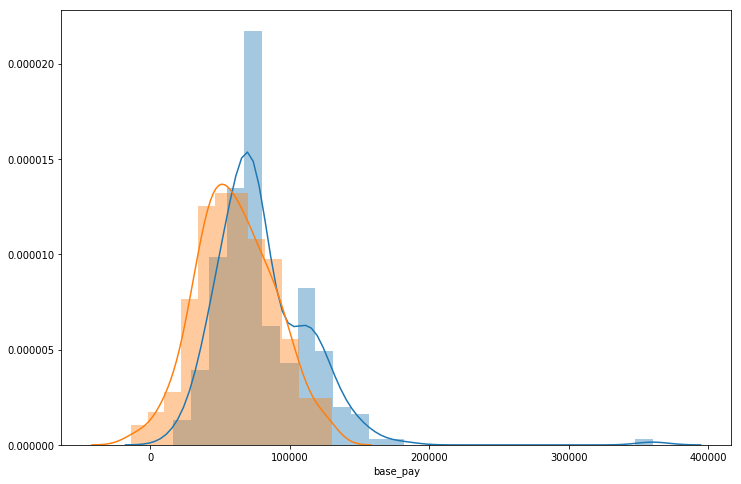

CS Mu: 80520.47 CS Sigma: 34295.74
CS Sample Percentile: 0.84
American Mu: 59000.00 American Sigma: 30000.00
American Sample Percentile: 0.97


In [36]:
# Probably More Representative since Linear Regression is a bad model for the data

data = data[(data.age >= test_age-1) & (data.age <= test_age+1)]
cs_mean = np.mean(data.base_pay)
cs_std = np.std(data.base_pay)

american_mean = 59000
american_std = 30000
avg_american = np.random.normal(american_mean, american_std, len(data.base_pay))

plt.figure(figsize=(12,8))
sns.distplot(data.base_pay)
sns.distplot(avg_american)
plt.show()


print("CS Mu: {0:.2f}".format(cs_mean), "CS Sigma: {0:.2f}".format(cs_std))
print("CS Sample Percentile: {0:.2f}".format(norm.cdf(test_pay, cs_mean, cs_std)))

print("American Mu: {0:.2f}".format(american_mean), "American Sigma: {0:.2f}".format(american_std))
print("American Sample Percentile: {0:.2f}".format(norm.cdf(test_pay, american_mean, american_std)))

In [44]:
print('t-statistic = %6.3f pvalue = %6.20f' %  stats.ttest_1samp(data.base_pay.values, american_mean))

t-statistic =  9.681 pvalue = 0.00000000000000000067


In [48]:
print("Percent More On Average: {0:.2f}%".format((cs_mean - american_mean)/american_mean * 100))

Percent More On Average: 36.48%
